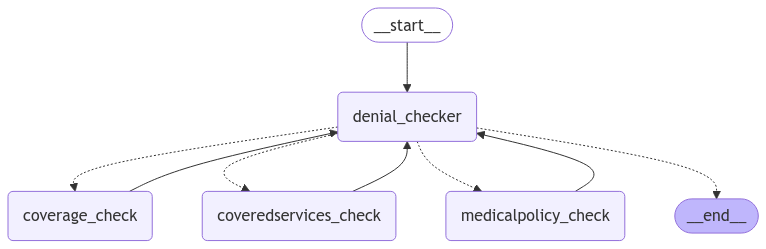

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_core.messages import  HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.memory import InMemoryStore
from IPython.display import Image, display
from  components.nodes import denial_checker, coveredservices_check, coverage_check, medicalpolicy_check
from  components.conditional_edges import route_message, intermediate 


import re
with open("./data/fifa2026.txt", encoding="utf8") as f:
    fifa = f.readlines()
    fifa = [item.strip() for item in fifa if item != '\n']
    msgs = []
    for i, text in enumerate(fifa):
        match = re.search(r'\[@([^\s]+)', text)
        rest, post = text.rsplit(sep="M]")
        if match and post:
            msgs.append({"user_id":match.group(1), "message":post})
        else:
            print(f"{i}: Not found")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") 
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

builder = StateGraph(MessagesState)

builder.add_node("denial_checker",denial_checker)
builder.add_node("coveredservices_check",coveredservices_check)
builder.add_node("coverage_check",coverage_check)
builder.add_node("medicalpolicy_check",coverage_check)
builder.add_edge(START, "denial_checker")
builder.add_conditional_edges("denial_checker", route_message, intermediate)
builder.add_edge("coveredservices_check", "denial_checker")
builder.add_edge("coverage_check", "denial_checker")
builder.add_edge("medicalpolicy_check", "denial_checker")
across_thread_memory = InMemoryStore()
within_thread_memory = MemorySaver()
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)


# for msg in msgs[:5]:
#     config = {"configurable": {"thread_id": "1", "user_id": msg["user_id"]}}
#     input_messages = [HumanMessage(content=msg["message"])]
#     messages = graph.invoke({"messages": input_messages}, config)

# for msg in msgs[0:5]:
#     namespace = ('profile', msg["user_id"])
#     memories = across_thread_memory.search(namespace)
#     print(f" {msg["user_id"]} {memories} \n" )
#     print("***************************************")
#     namespace = ('todo', msg["user_id"])
#     memories = across_thread_memory.search(namespace)
#     print(f" {msg["user_id"]} {memories} \n" )
#     print("***************************************")
#     namespace = ('instructions', msg["user_id"])
#     memories = across_thread_memory.search(namespace)
#     print(f" {msg["user_id"]} {memories} \n" )
#     print("***************************************")
    
display(Image(graph.get_graph().draw_mermaid_png()))
